<a href="https://colab.research.google.com/github/arkincognito/PyTorch/blob/main/08_01_Pytorch_MNIST_DNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron


## What is perceptron?

Perceptron is a network layer composed with linear combination and activation function.
$$ z^{(j)}= x^{(j)}\times W + b = \begin{pmatrix}
x^{(j)}_1 & x^{(j)}_2 & \cdots & x^{(j)}_n\\
\end{pmatrix}
\times
\begin{pmatrix}
w_1\\
w_2\\
\vdots\\
w_n
\end{pmatrix} + b$$
$$y^{(j)}_{pred} = activaton(z^{(j)})$$

where suffix (j) represents the jth data. $x^{(j)}$ represents the jth input and $y^{(j)}$ represents the jth label.

# XOR problem

Perceptron can be used to solve AND and OR problems.<br>
However, to solve XOR problem, we need Multi Layer Perceptron, MLP.

# MLP

MLP is a sequence of perceptrons.<br>
It seemed impossible to get the gradient of loss on arbitrary MLP. But now, with the help of computational graph, back propagation of MLP can be done easily.

# Vanishing Gradient
The gradient of sigmoid $\sigma(x)$ is:
$${d\over dx}\sigma(x) = \sigma(x)(1 - \sigma(x))$$
As $\sigma(x)$ approaches 0 on the left side of the graph and 1 on the right side of the graph, the gradient approaches 0 on either end of the graph.<br>
When this small gradient value stacks by MLP, back propagation tends to 'Vanish' as we move over to the input end of the net.<br>
To solve this Vanishing Gradient problem, we use other activation functions as ReLU, Tanh, Leaky-ReLU, and so on.

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import time

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(13)
torch.manual_seed(13)
if device == 'cuda':
    torch.cuda.manual_seed_all(13)

In [3]:
# MNIST dataset
# Note that ToTensor() scales input range from [0,255] to [0.0,1.0].
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Hyper Parameters
training_epochs = 1
batch_size = 8
lr = 0.001

In [5]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

Instead of using Module, let's build the model with simple Sequential.

In [6]:
linear1 = nn.Linear(784, 256, bias=True).to(device)
linear2 = nn.Linear(256, 64, bias=True).to(device)
linear3 = nn.Linear(64, 10, bias=True).to(device)
relu = nn.ReLU()

# Weight Initialization
nn.init.normal_(linear1.weight)
nn.init.normal_(linear2.weight)
nn.init.normal_(linear3.weight)

model = nn.Sequential(linear1, relu, linear2, relu, linear3)

In [7]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
total_batch = len(data_loader)
train_start = time.time()
for epoch in range(1, training_epochs+1):
    avg_cost = 0

    for  x, y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        x = x.view(-1, 28 * 28).to(device)
        y = y.to(device)

        hypothesis = model(x)
        cost = criterion(hypothesis, y)

        # Initialize all the gradients to zero
        optimizer.zero_grad()
        # Backward Propagation
        cost.backward()
        # Update
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    
    print(f'Epoch: {epoch:4d}/{training_epochs:4d}\tcost = {avg_cost:.9f}')
training_time = time.time() - train_start
print(f'Learning finished, training time on {training_epochs} epoch: {training_time:.4f} seconds')

Epoch:    1/   1	cost = 28.296283722
Learning finished, training time on 1 epoch: 20.6392 seconds


Testing time on 10000 test data: 0.0322
Accuracy: 0.6581999659538269
Label:  6
Prediction:  6


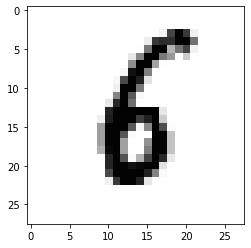

In [9]:
# Test the model using test sets
test_start = time.time()
with torch.no_grad(): # Indicates that gradients will not be calculated
    x_test = mnist_test.data.view(-1, 28 * 28).float().to(device)
    y_test = mnist_test.targets.to(device)
    # Take Argmax of softmax to predict the class
    #prediction = model(x_test).max(dim=1)[1]
    prediction = torch.argmax(model(x_test), 1)
    accuracy = (prediction == y_test).float().mean()
    testing_time = time.time() - test_start
    print(f'Testing time on {len(x_test)} test data: {testing_time:.4f}')
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    x_single_data = mnist_test.data[r].view(-1, 28 * 28).float().to(device)
    y_single_data = mnist_test.targets[r].to(device)

    testing_time = time.time() - test_start
    print('Label: ', y_single_data.item())
    single_prediction = model(x_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.data[r].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

It takes 41 seconds to go through SINGLE epoch on Google Colab provided GPU.<br>
Next, I'll use multi core TPU to speed up the training process.